In [1]:
# Inspired by this :https://towardsdatascience.com/deep-learning-on-point-clouds-implementing-pointnet-in-google-colab-1fd65cd3a263

# loading packages
import os
import time
import math
import random
import pandas
import itertools
import numpy as np
from path import Path
import scipy.spatial.distance
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import plotly.graph_objects as go
import plotly.express as px

random.seed = 42

In [2]:
# Cleaning up GPU memory and check the available GPU device 
torch.cuda.empty_cache()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [3]:
path = Path("./ModelNet10")

In [4]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

## Data Processing

In [5]:
# read the .off file and obtain the information from pointcloud data
def read_off(file):
    # 读取文件头并检查格式  Read the file header and check the format
    off_header = file.readline().strip()
    if off_header != 'OFF':
        raise ValueError('Not a valid OFF header')

    # 读取顶点和面数量  Read the number of vertices and faces
    n_verts, n_faces, _ = map(int, file.readline().strip().split())

    # 读取顶点坐标 Read vertex coordinates
    verts = [list(map(float, file.readline().strip().split())) for _ in range(n_verts)]

    # 读取面信息 Read face information
    faces = [list(map(int, file.readline().strip().split()))[1:] for _ in range(n_faces)]

    return verts, faces

In [6]:
# Use Heron's formula to calculate the area of ​​a triangle formed by three points, 
# and the area of ​​each triangle is used as a weight to randomly select a certain number of faces and sample points on these faces.
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points


In [7]:
# Normalize the point cloud data after randomly selecting points
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [8]:
#Rotate the point cloud at random angles with the z axis as the axis
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
        
# Add random noise    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [9]:
# Convert data into tensors
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [10]:
# Integrate the above data processing methods
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Make the Dataset

In [11]:
# Read point cloud data and encapsulate it into a dictionary. Each point cloud data corresponds to its label.
class PointCloudData(Dataset):
    def __init__(self, root_dir, test=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not test else default_transforms()
        self.test = test
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [12]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [13]:
train_ds = PointCloudData(path, transform=train_transforms)
test_ds = PointCloudData(path, test=True, folder='test')

In [14]:
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))

Train dataset size:  3991
Test dataset size:  908


In [15]:
# split the dataset: train:valid = 9:1 按9比1的分割训练数据集：训练集：9； 验证集：1
def train_val_split(train_ds):
    train_size = int(len(train_ds) * 0.90)
    val_size = len(train_ds) - train_size
     
    train_ds, val_ds = random_split(train_ds, [train_size, val_size])
    return train_ds, val_ds

In [16]:
train_ds, valid_ds = train_val_split(train_ds)

In [17]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))

Train dataset size:  3591
Valid dataset size:  400


In [18]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [14]:
test_loader = DataLoader(dataset=test_ds, batch_size=64)

In [20]:
len(test_loader)

15

In [15]:
# PointNet Network
class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [16]:
# The loss is calculated by the weighted sum of the classification loss and the regularization loss.
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    
    bs = outputs.size(0)
    id3x3 = torch.eye(3, device=outputs.device).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, device=outputs.device).repeat(bs, 1, 1)

    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))

    loss = criterion(outputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)
    return loss

## Training

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
pointnet = PointNet()
pointnet.to(device);pointnet = PointNet()
pointnet.to(device);

In [30]:
save_path = './pointnet_cls_train/ModelNet10'

# Optimizer, learning rate = 0.001, lr2 = 0.0001
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001, weight_decay=1e-4)

def train(model, train_loader, val_loader=None, epochs=15, save=False, save_path=save_path):

    # Record training loss and accuracy
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    scaler = torch.cuda.amp.GradScaler()  # For half-precision(float16) training

    total_start_time = time.time()  #  Record total training start time

    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()  # Record the start time of each epoch
        correct = total = 0  # Used to calculate training accuracy

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)

            optimizer.zero_grad()
            
            # Using Automatic Mixed Precision
            with torch.cuda.amp.autocast():
                outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))
                loss = pointnetloss(outputs, labels, m3x3, m64x64)

            # Backpropagation
            scaler.scale(loss).backward()  # Half-precision backpropagation
            scaler.step(optimizer)  # Update Optimizer
            scaler.update()  # Update the scaler

            # Record loss
            running_loss += loss.item()

            # Calculate the training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 9:    # Print every 10 small batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        # record training loss and accuracy of each epoch
        train_losses.append(running_loss)
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)

        #  print the time cost of each epoch
        epoch_time = time.time() - epoch_start_time
        print('Epoch %d finished in %.2f seconds. Training Accuracy: %.2f %%' % (epoch + 1, epoch_time, train_accuracy))

        # Evaluate the Model
        model.eval()
        correct = total = 0

        # Use valid dataset to test the model at training process
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    with torch.cuda.amp.autocast(): 
                        outputs, __, __ = model(inputs.transpose(1, 2))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            val_accuracies.append(val_acc)
            print('Valid accuracy: %.2f %%' % val_acc)

            # Save the best model
            if val_acc > best_val_acc:  
                best_val_acc = val_acc
                if save:
                    torch.save(model.state_dict(), f"{save_path}/best_pointnet10_cls.pth")
                    print('Best model saved with accuracy: %.2f %%' % best_val_acc)

    # Print the total time cost of training
    total_time = time.time() - total_start_time
    print('Total training time: %.2f seconds.' % total_time)

    # plot and save the loss cruve
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.savefig(f"{save_path}/training_loss_curve.png")
    plt.close()

    # plot and save the accuracy cruve
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    if val_loader:
        plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Curve')
    plt.legend()
    plt.savefig(f"{save_path}/training_validation_accuracy_curve.png")
    plt.close()

In [31]:
train(pointnet, train_loader, valid_loader, save=True, save_path=save_path)

[Epoch: 1, Batch:   10 /  113], loss: 0.961
[Epoch: 1, Batch:   20 /  113], loss: 1.078
[Epoch: 1, Batch:   30 /  113], loss: 0.993
[Epoch: 1, Batch:   40 /  113], loss: 0.815
[Epoch: 1, Batch:   50 /  113], loss: 0.845
[Epoch: 1, Batch:   60 /  113], loss: 0.797
[Epoch: 1, Batch:   70 /  113], loss: 0.776
[Epoch: 1, Batch:   80 /  113], loss: 0.733
[Epoch: 1, Batch:   90 /  113], loss: 0.756
[Epoch: 1, Batch:  100 /  113], loss: 0.724
[Epoch: 1, Batch:  110 /  113], loss: 0.761
Epoch 1 finished in 470.04 seconds. Training Accuracy: 72.01 %
Valid accuracy: 72.50 %
Best model saved with accuracy: 72.50 %
[Epoch: 2, Batch:   10 /  113], loss: 0.687
[Epoch: 2, Batch:   20 /  113], loss: 0.771
[Epoch: 2, Batch:   30 /  113], loss: 0.672
[Epoch: 2, Batch:   40 /  113], loss: 0.603
[Epoch: 2, Batch:   50 /  113], loss: 0.640
[Epoch: 2, Batch:   60 /  113], loss: 0.731
[Epoch: 2, Batch:   70 /  113], loss: 0.717
[Epoch: 2, Batch:   80 /  113], loss: 0.701
[Epoch: 2, Batch:   90 /  113], loss:

In [57]:
torch.cuda.empty_cache()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [18]:
pre_train_path = './pointnet_cls_train/ModelNet10/best_pointnet10_cls.pth'
pointnet = PointNet()
pointnet.load_state_dict(torch.load(pre_train_path))
pointnet.eval();

In [20]:
# Class number
num_classes = 10 

# Record the predicted one and true label
class_correct = [0] * num_classes
class_total = [0] * num_classes

# Calculate the total corret one and total sample
total_correct = 0
total_samples = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i + 1, len(test_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        
        # obtain the predicted label
        _, preds = torch.max(outputs.data, 1)
        
        # Update all predictions and labels
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

        # Count the number of correct predictions for each category and the total number
        for j in range(labels.size(0)):
            label = labels[j].item()  # Get the true label of the current sample
            class_total[label] += 1  # The total number of samples in this category plus 1
            
            # If the prediction is correct, the number of correct predictions for the corresponding category increases by 1
            class_correct[label] += (preds[j] == label).item()  
            
            # Update global statistics
            total_samples += 1
            total_correct += (preds[j] == label).item()

# Calculate the accuracy for each class
class_accuracy = [0] * num_classes
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy[i] = class_correct[i] / class_total[i]
    else:
        class_accuracy[i] = 0.0  # If there is no sample in this class, the accuracy is 0

# Calculate the overall classification accuracy
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

# Print the number of tests and accuracy for each category
for i in range(num_classes):
    print(f'Class {i}: Total = {class_total[i]}, Correct = {class_correct[i]}, Accuracy = {class_accuracy[i]:.4f}')

# Print overall classification accuracy
print(f'Overall Accuracy: {overall_accuracy:.4f}')

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
Class 0: Total = 50, Correct = 40, Accuracy = 0.8000
Class 1: Total = 100, Correct = 83, Accuracy = 0.8300
Class 2: Total = 100, Correct = 94, Accuracy = 0.9400
Class 3: Total = 86, Correct = 58, Accuracy = 0.6744
Class 4: Total = 86, Correct = 67, Accuracy = 0.7791
Class 5: Total = 100, Correct = 93, Accuracy = 0.9300
Class 6: Total = 86, Correct = 56, Accuracy = 0.6512
Class 7: Total = 100, Correct = 95, Accuracy = 0.9500
Class 8: Total = 100, Correct = 86, Accuracy = 0.8600
Class 9: Total = 100, Correct = 87, Accuracy = 0.8700
Overall Accuracy: 0.8359


In [21]:
# Use all labels and all predited label to draw Confusion Matrix 
cm = confusion_matrix(all_labels, all_preds);
print("Confusion Matrix: \n",cm)

Confuse Matrix: 
 [[40  4  0  0  0  0  0  5  0  1]
 [ 4 83  3  1  0  0  0  6  3  0]
 [ 0  0 94  0  0  0  0  1  0  5]
 [ 0  0  0 58  2  2  5  5 12  2]
 [ 0  0  0  2 67  1 15  0  0  1]
 [ 0  0  2  0  2 93  0  0  0  3]
 [ 0  0  0  1 27  0 56  0  1  1]
 [ 0  0  0  2  1  0  1 95  0  1]
 [ 0  0  0 14  0  0  0  0 86  0]
 [ 0  0  1  2  0  3  3  0  4 87]]


In [27]:
# Calculate TP, FP, FN
TP = cm.diagonal()  # Diagonal elements
FP = cm.sum(axis=0) - TP  # The sum of each column minus TP
FN = cm.sum(axis=1) - TP  # The sum of each row minus TP

#  Calculate accuracy, precision, recall and f1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:\n", accuracy)
print("Precision:\n", precision)
print("Recall:\n", recall)
print("F1-score:\n", f1)

准确率:
 0.8359030837004405
精确率:
 [0.90909091 0.95402299 0.94       0.725      0.67676768 0.93939394
 0.7        0.84821429 0.81132075 0.86138614]
召回率:
 [0.8        0.83       0.94       0.6744186  0.77906977 0.93
 0.65116279 0.95       0.86       0.87      ]
F1-score:
 [0.85106383 0.88770053 0.94       0.69879518 0.72432432 0.93467337
 0.6746988  0.89622642 0.83495146 0.86567164]


In [30]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Confusion Matrix_ModelNet10_opt.png', dpi=300)

Normalized confusion matrix


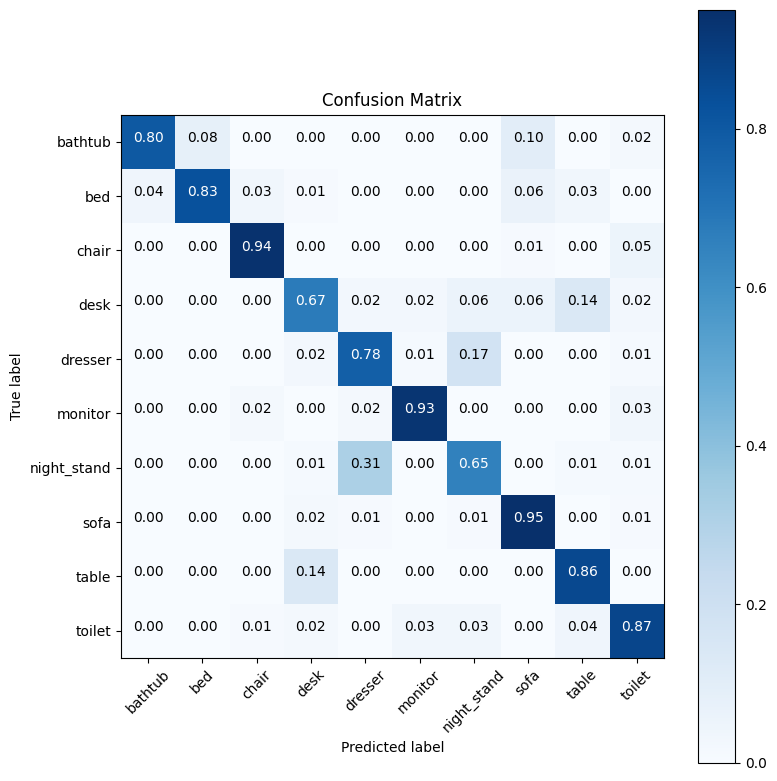

In [26]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

## Optimization Part

### Calculate the class weights

In [36]:
inverse_accuracy = 1 - np.array(class_accuracy)  # inverse accuracy
weights = inverse_accuracy * class_total  

# Normalized weights
weights /= np.sum(weights)  # 使总和为1

# convert weights array to tensor
class_weights = torch.tensor(weights, dtype=torch.float)

print("Calculated class weights:", class_weights)

Calculated class weights: tensor([0.0638, 0.1135, 0.0496, 0.1986, 0.1418, 0.0426, 0.1844, 0.0426, 0.0780,
        0.0851])


### Introducing new data augmentation methods

In [39]:
def generate_sphere(center, radius, num_points):
    """Generate a point cloud of a sphere"""
    u = np.random.uniform(0, 1, num_points)
    v = np.random.uniform(0, 1, num_points)
    
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)

    # Convert from spherical coordinate system to three-dimensional Cartesian coordinate system
    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return np.column_stack((x, y, z))

def apply_occlusion(pointcloud, sphere_center, sphere_radius):
    """Synthesize the generated sphere with the original point cloud data and delete the point cloud data inside the sphere"""
    distances = np.linalg.norm(pointcloud - sphere_center, axis=1)
    occluded_pointcloud = pointcloud[distances > sphere_radius]
    return occluded_pointcloud

def pad_or_crop(pointcloud, target_size):
   """Pad or crop the point cloud to the target size"""
    current_size = pointcloud.shape[0]
    if current_size < target_size:
        padding = np.zeros((target_size - current_size, pointcloud.shape[1]), dtype=pointcloud.dtype)
        return np.vstack((pointcloud, padding))  # Stacking on the first dimension
    elif current_size > target_size:
        return pointcloud[:target_size]  # Crop to target size
    return pointcloud

# Integrated generate_sphere, apply_occlusion and pad_or_crop
class Sphere_Occlusion(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        random_index = np.random.randint(0, pointcloud.shape[0])
        sphere_center = pointcloud[random_index]
        
        sphere_radius = 0.2
        num_sphere_points = 400

        sphere_pointcloud = generate_sphere(sphere_center, sphere_radius, num_sphere_points)
        
        occluded_pointcloud = apply_occlusion(pointcloud, sphere_center, sphere_radius)

        return pad_or_crop(occluded_pointcloud, 1024)

# The coordinates of each point are offset with a moving range of ±0.1
class RandomShift(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        shift_range = 0.1

        shifts = np.random.uniform(-shift_range, shift_range, pointcloud.shape)
        shifted_pointcloud = pointcloud + shifts
        
        return pad_or_crop(shifted_pointcloud, 1024)

# A random scaling factor ranging from 0.8 to 1.25 is multiplied by the coordinates of each point, so that the entire point cloud is scaled.
class RandomScale(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        scale_low = 0.8
        scale_high = 1.25
        scales = np.random.uniform(scale_low, scale_high, (pointcloud.shape[0], 1))
        scaled_pointcloud = pointcloud * scales
        
        return pad_or_crop(scaled_pointcloud, 1024)

In [40]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    Sphere_Occlusion(),
                    RandomShift(),
                    RandomScale(),
                    ToTensor()
                    ])
train_ds = PointCloudData(path, transform=train_transforms)
test_ds = PointCloudData(path, test=True, folder='test')

In [41]:
train_ds = PointCloudData(path, transform=train_transforms)
test_ds = PointCloudData(path, test=True, folder='test')

In [82]:
'''
def check_tensor_shapes(dataset):
    # 获取第一个样本的形状作为基准
    first_shape = None

    for i, data in enumerate(dataset):
        # 假设每个样本是一个字典，包含 'pointcloud' 和 'category'
        tensor = data['pointcloud']  # 替换为您的张量键

        # 检查张量的形状
        if first_shape is None:
            first_shape = tensor.shape
        else:
            if tensor.shape != first_shape:
                print(f"Mismatch found in sample {i}: {tensor.shape} vs {first_shape}")
                return False

    print("All tensors have the same shape:", first_shape)
    return True

# 使用示例
check_tensor_shapes(train_ds)
'''

All tensors have the same shape: torch.Size([1024, 3])


True

In [48]:
print('Train dataset size: ', len(train_ds))
print('Test dataset size: ', len(test_ds))

Train dataset size:  3591
Test dataset size:  908


In [44]:
train_ds, valid_ds = train_val_split(train_ds)

In [46]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)
test_loader = DataLoader(dataset=test_ds, batch_size=64)

### Loss function with class weights

In [49]:
def pointnetloss(outputs, labels, m3x3, m64x64, class_weights=None, alpha=0.0001):
    # Convert outputs to log probabilities if they are logits
    log_probs = torch.nn.functional.log_softmax(outputs, dim=1)

    if class_weights is not None:
        class_weights = class_weights.to(outputs.device)

    # Use weighted negative log likelihood loss
    criterion = torch.nn.NLLLoss(weight=class_weights) if class_weights is not None else torch.nn.NLLLoss()
    
    bs = outputs.size(0)  # Get batch size

    # Create identity matrices
    id3x3 = torch.eye(3, device=outputs.device).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, device=outputs.device).repeat(bs, 1, 1)

    # Calculate differences
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))

    # Calculate total loss
    loss = criterion(log_probs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)
    
    return loss

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
pointnet.load_state_dict(torch.load(pre_train_path))
pointnet = PointNet()
pointnet.to(device);pointnet = PointNet()
pointnet.to(device);

In [52]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001, weight_decay=1e-4)

In [53]:
save_path = './pointnet_cls_train/ModelNet10'

optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001, weight_decay=1e-4)

def train(model, train_loader, val_loader=None, epochs=15, class_weights = None, save=False, save_path=save_path):

    # Record training loss and accuracy
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0.0  # Initialize the best validation accuracy
    scaler = torch.cuda.amp.GradScaler()  # For half-precision(float16) training

    total_start_time = time.time()  #  Record total training start time

    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()  # Record the start time of each epoch
        correct = total = 0  # Used to calculate training accuracy

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)

            optimizer.zero_grad()
            
            # Using Automatic Mixed Precision
            with torch.cuda.amp.autocast():
                outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))
                loss = pointnetloss(outputs, labels, m3x3, m64x64, class_weights)

            # Backpropagation
            scaler.scale(loss).backward()  # Half-precision backpropagation
            scaler.step(optimizer)  # Update Optimizer
            scaler.update()  # Update the scaler

            # Record loss
            running_loss += loss.item()

            # Calculate the training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 9:    # Print every 10 small batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        # record training loss and accuracy of each epoch
        train_losses.append(running_loss)
        train_accuracy = 100. * correct / total
        train_accuracies.append(train_accuracy)

        #  print the time cost of each epoch
        epoch_time = time.time() - epoch_start_time
        print('Epoch %d finished in %.2f seconds. Training Accuracy: %.2f %%' % (epoch + 1, epoch_time, train_accuracy))

        # Evaluate the Model
        model.eval()
        correct = total = 0

        # Use valid dataset to test the model at training process
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    with torch.cuda.amp.autocast(): 
                        outputs, __, __ = model(inputs.transpose(1, 2))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

            val_acc = 100. * correct / total
            val_accuracies.append(val_acc)
            print('Valid accuracy: %.2f %%' % val_acc)

            # Save the best model
            if val_acc > best_val_acc:  
                best_val_acc = val_acc
                if save:
                    torch.save(model.state_dict(), f"{save_path}/best_pointnet10_cls.pth")
                    print('Best model saved with accuracy: %.2f %%' % best_val_acc)

    # Print the total time cost of training
    total_time = time.time() - total_start_time
    print('Total training time: %.2f seconds.' % total_time)

    # plot and save the loss cruve
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.savefig(f"{save_path}/training_loss_curve.png")
    plt.close()

    # plot and save the accuracy cruve
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    if val_loader:
        plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy Curve')
    plt.legend()
    plt.savefig(f"{save_path}/training_validation_accuracy_curve.png")
    plt.close()

In [54]:
train(pointnet, train_loader, valid_loader, class_weights=class_weights, save=True, save_path=save_path)

[Epoch: 1, Batch:   10 /  113], loss: 2.161
[Epoch: 1, Batch:   20 /  113], loss: 1.725
[Epoch: 1, Batch:   30 /  113], loss: 1.311
[Epoch: 1, Batch:   40 /  113], loss: 1.248
[Epoch: 1, Batch:   50 /  113], loss: 1.279
[Epoch: 1, Batch:   60 /  113], loss: 1.101
[Epoch: 1, Batch:   70 /  113], loss: 0.967
[Epoch: 1, Batch:   80 /  113], loss: 0.963
[Epoch: 1, Batch:   90 /  113], loss: 0.780
[Epoch: 1, Batch:  100 /  113], loss: 0.884
[Epoch: 1, Batch:  110 /  113], loss: 0.776
Epoch 1 finished in 409.39 seconds. Training Accuracy: 62.38 %
Valid accuracy: 64.00 %
Best model saved with accuracy: 64.00 %
[Epoch: 2, Batch:   10 /  113], loss: 0.791
[Epoch: 2, Batch:   20 /  113], loss: 0.688
[Epoch: 2, Batch:   30 /  113], loss: 0.746
[Epoch: 2, Batch:   40 /  113], loss: 0.851
[Epoch: 2, Batch:   50 /  113], loss: 0.747
[Epoch: 2, Batch:   60 /  113], loss: 0.780
[Epoch: 2, Batch:   70 /  113], loss: 0.840
[Epoch: 2, Batch:   80 /  113], loss: 0.695
[Epoch: 2, Batch:   90 /  113], loss:

In [28]:
pre_train_path_opt = './pointnet_cls_train/ModelNet10/best_pointnet10_cls_opt1.pth'
pointnet = PointNet()
pointnet.load_state_dict(torch.load(pre_train_path_opt))
pointnet.eval();

In [29]:
# Class number
num_classes = 10 

# Record the predicted one and true label
class_correct = [0] * num_classes
class_total = [0] * num_classes

# Calculate the total corret one and total sample
total_correct = 0
total_samples = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        print('Batch [%4d / %4d]' % (i + 1, len(test_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        
        # obtain the predicted label
        _, preds = torch.max(outputs.data, 1)
        
        # Update all predictions and labels
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

        # Count the number of correct predictions for each category and the total number
        for j in range(labels.size(0)):
            label = labels[j].item()  # Get the true label of the current sample
            class_total[label] += 1  # The total number of samples in this category plus 1
            
            # If the prediction is correct, the number of correct predictions for the corresponding category increases by 1
            class_correct[label] += (preds[j] == label).item()  
            
            # Update global statistics
            total_samples += 1
            total_correct += (preds[j] == label).item()

# Calculate the accuracy for each class
class_accuracy = [0] * num_classes
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy[i] = class_correct[i] / class_total[i]
    else:
        class_accuracy[i] = 0.0  # If there is no sample in this class, the accuracy is 0

# Calculate the overall classification accuracy
overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

# Print the number of tests and accuracy for each category
for i in range(num_classes):
    print(f'Class {i}: Total = {class_total[i]}, Correct = {class_correct[i]}, Accuracy = {class_accuracy[i]:.4f}')

# Print overall classification accuracy
print(f'Overall Accuracy: {overall_accuracy:.4f}')

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]
Class 0: Total = 50, Correct = 35, Accuracy = 0.7000
Class 1: Total = 100, Correct = 100, Accuracy = 1.0000
Class 2: Total = 100, Correct = 97, Accuracy = 0.9700
Class 3: Total = 86, Correct = 75, Accuracy = 0.8721
Class 4: Total = 86, Correct = 63, Accuracy = 0.7326
Class 5: Total = 100, Correct = 91, Accuracy = 0.9100
Class 6: Total = 86, Correct = 75, Accuracy = 0.8721
Class 7: Total = 100, Correct = 97, Accuracy = 0.9700
Class 8: Total = 100, Correct = 97, Accuracy = 0.9700
Class 9: Total = 100, Correct = 85, Accuracy = 0.8500
Overall Accuracy: 0.8976


In [33]:
cm1 = confusion_matrix(all_labels, all_preds);
print("Confusion Matrix: \n",cm)

Confusion Matrix: 
 [[40  4  0  0  0  0  0  5  0  1]
 [ 4 83  3  1  0  0  0  6  3  0]
 [ 0  0 94  0  0  0  0  1  0  5]
 [ 0  0  0 58  2  2  5  5 12  2]
 [ 0  0  0  2 67  1 15  0  0  1]
 [ 0  0  2  0  2 93  0  0  0  3]
 [ 0  0  0  1 27  0 56  0  1  1]
 [ 0  0  0  2  1  0  1 95  0  1]
 [ 0  0  0 14  0  0  0  0 86  0]
 [ 0  0  1  2  0  3  3  0  4 87]]


In [34]:
# Calculate TP, FP, FN
TP = cm.diagonal()  # Diagonal elements
FP = cm.sum(axis=0) - TP  # The sum of each column minus TP
FN = cm.sum(axis=1) - TP  # The sum of each row minus TP

#  Calculate accuracy, precision, recall and f1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:\n", accuracy)
print("Precision:\n", precision)
print("Recall:\n", recall)
print("F1-score:\n", f1)

准确率:
 0.8975770925110133
精确率:
 [1.         0.81967213 0.91509434 0.85227273 0.85135135 0.98913043
 0.76530612 0.96039604 0.90654206 1.        ]
召回率:
 [0.7        1.         0.97       0.87209302 0.73255814 0.91
 0.87209302 0.97       0.97       0.85      ]
F1-score:
 [0.82352941 0.9009009  0.94174757 0.86206897 0.7875     0.94791667
 0.81521739 0.96517413 0.93719807 0.91891892]


Normalized confusion matrix


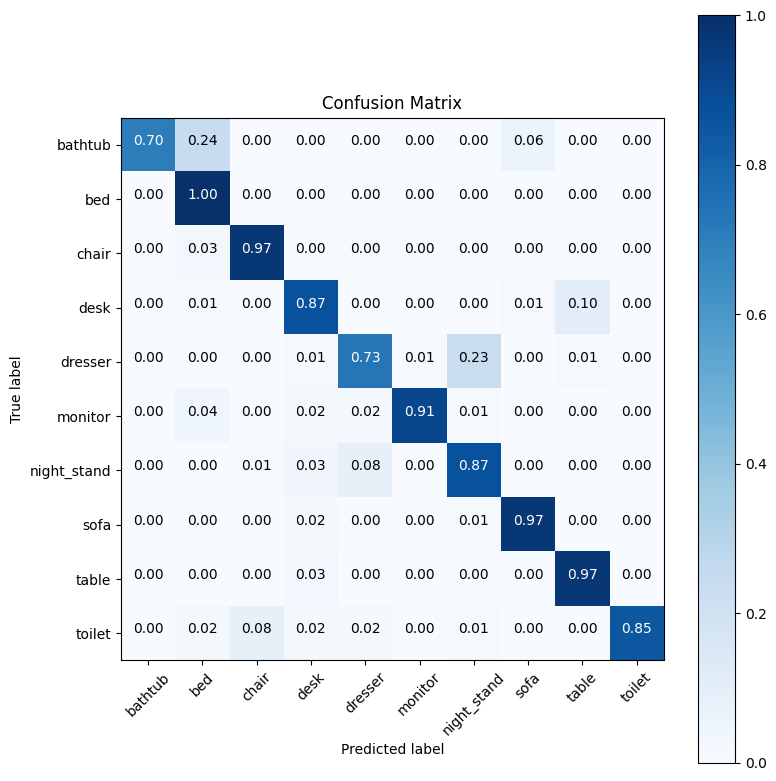

In [35]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm1, list(classes.keys()), normalize=True)

## Use 5 sets of random seeds to generate test sets for testing

In [88]:
# Number of class
num_classes = 10
num_seeds = 5

# Stores the accuracy of each seed and statistics for each class
class_correct = np.zeros((num_seeds, num_classes))
class_total = np.zeros((num_seeds, num_classes))
overall_accuracy = np.zeros(num_seeds)

# Perform 5 experiments with different random seeds
for seed in range(num_seeds):
    np.random.seed(seed)
    torch.manual_seed(seed)
 
    test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=False)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            print(f'Batch [{i + 1} / {len(test_loader)}] with seed {seed + 1}')

            inputs, labels = data['pointcloud'].float(), data['category']

            outputs, __, __ = pointnet(inputs.transpose(1, 2))
            
            _, preds = torch.max(outputs, 1)

            # Update per-class and global statistics
            for j in range(labels.size(0)):
                label = labels[j].item()  # Get the true label of the current sample
                class_total[seed, label] += 1  # The total number of samples in this category plus 1

                #If the prediction is correct, the number of correct predictions for the corresponding category increases by 1
                class_correct[seed, label] += (preds[j] == label).item()
                
                total_samples += 1
                total_correct += (preds[j] == label).item()

    # Calculate the overall classification accuracy for each seed
    overall_accuracy[seed] = total_correct / total_samples if total_samples > 0 else 0.0

# Calculate the average accuracy for each class
average_class_accuracy = np.zeros(num_classes)
for i in range(num_classes):
    total_correct = np.sum(class_correct[:, i])
    total_samples = np.sum(class_total[:, i])
    if total_samples > 0:
        average_class_accuracy[i] = total_correct / total_samples
    else:
        average_class_accuracy[i] = 0.0  # If there is no sample in this class, the accuracy is 0

# Calculate the average accuracy of the 5 test sets
average_overall_accuracy = np.mean(overall_accuracy)

# Print the number of tests and accuracy for each category
for i in range(num_classes):
    print(f'Class {i}: Total = {np.sum(class_total[:, i])}, Correct = {np.sum(class_correct[:, i])}, Average Accuracy = {average_class_accuracy[i]:.4f}')

# Print overall classification accuracy
print(f'Average Overall Accuracy: {average_overall_accuracy:.4f}')

Batch [1 / 15] with seed 1
Batch [2 / 15] with seed 1
Batch [3 / 15] with seed 1
Batch [4 / 15] with seed 1
Batch [5 / 15] with seed 1
Batch [6 / 15] with seed 1
Batch [7 / 15] with seed 1
Batch [8 / 15] with seed 1
Batch [9 / 15] with seed 1
Batch [10 / 15] with seed 1
Batch [11 / 15] with seed 1
Batch [12 / 15] with seed 1
Batch [13 / 15] with seed 1
Batch [14 / 15] with seed 1
Batch [15 / 15] with seed 1
Batch [1 / 15] with seed 2
Batch [2 / 15] with seed 2
Batch [3 / 15] with seed 2
Batch [4 / 15] with seed 2
Batch [5 / 15] with seed 2
Batch [6 / 15] with seed 2
Batch [7 / 15] with seed 2
Batch [8 / 15] with seed 2
Batch [9 / 15] with seed 2
Batch [10 / 15] with seed 2
Batch [11 / 15] with seed 2
Batch [12 / 15] with seed 2
Batch [13 / 15] with seed 2
Batch [14 / 15] with seed 2
Batch [15 / 15] with seed 2
Batch [1 / 15] with seed 3
Batch [2 / 15] with seed 3
Batch [3 / 15] with seed 3
Batch [4 / 15] with seed 3
Batch [5 / 15] with seed 3
Batch [6 / 15] with seed 3
Batch [7 / 15] w